In [ ]:
import torch.nn as nn
import numpy as np
import pandas as pd
import os,time,gc
from PIL import Image
from zipfile import ZipFile 
import torch.nn as nn
import torch.nn.functional as F
from skimage import io,transform
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torch import nn
from albumentations import (HorizontalFlip, Flip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
import cv2, os, time
from albumentations.pytorch import ToTensor
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
import shutil
from tqdm import tqdm_notebook as tqdm
import warnings
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings("ignore")


from torch.utils.tensorboard import SummaryWriter
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
print (torch.__version__)

1.8.1+cu101


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/My Drive/SIIM')


In [ ]:
# import zipfile
# with zipfile.ZipFile('data/image_masks.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/drive/My Drive/SIIM/data')

In [ ]:
!ls data/out

processed.csv  sample_submission.csv  test  train


In [ ]:
!pip install torch-summary
!pip install segmentation_models_pytorch

In [ ]:
train_dir = 'data/out/train'
test_dir = 'data/out/test'
csv = 'data/out/processed.csv'
test_csv = 'data/out/sample_submission.csv'

In [ ]:
df = pd.read_csv(csv)
df.head()

,UID,EncodedPixels,Age,Sex,Modality,BodyPart,ViewPosition,filepath,Pneumothorax
0,1.2.276.0.7230010.3.1.4.8323329.1000.151787516...,-1,38,M,CR,CHEST,PA,../input/siim-train-test/dicom-images-train/1....,0
1,1.2.276.0.7230010.3.1.4.8323329.10000.15178752...,-1,10,F,CR,CHEST,AP,../input/siim-train-test/dicom-images-train/1....,0
2,1.2.276.0.7230010.3.1.4.8323329.10001.15178752...,-1,50,F,CR,CHEST,AP,../input/siim-train-test/dicom-images-train/1....,0
3,1.2.276.0.7230010.3.1.4.8323329.10002.15178752...,-1,68,F,CR,CHEST,AP,../input/siim-train-test/dicom-images-train/1....,0
4,1.2.276.0.7230010.3.1.4.8323329.10003.15178752...,-1,65,M,CR,CHEST,AP,../input/siim-train-test/dicom-images-train/1....,0


In [ ]:
# Here out RLE encoding is little bit different
def rle2mask(rles, width, height):
    """
    
    rle encoding if images
    input: rles(list of rle), width and height of image
    returns: mask of shape (width,height)
    """
    
    mask= np.zeros(width* height)
    for rle in rles:
        array = np.asarray([int(x) for x in rle.split()])
        starts = array[0::2]
        lengths = array[1::2]

        current_position = 0
        for index, start in enumerate(starts):
            current_position += start
            mask[current_position:current_position+lengths[index]] = 1
            current_position += lengths[index]

    return mask.reshape(width, height).T


def generate_df(df,folds=5):
    # sample equal number of 1 and 0 samples
    df1 = df[df['Pneumothorax'] == 1]
    df2 = df[df['Pneumothorax'] == 0]
    df2 = df2.sample(n=df1.shape[0],random_state=100)
    df = df1.append(df2).sample(frac=1).reset_index(drop=True)
    train_df,val_df = train_test_split(df,test_size=0.2,stratify=df["Pneumothorax"],random_state=100)
    train_df, val_df = train_df.reset_index(drop=True),val_df.reset_index(drop=True)
    return train_df,val_df


def get_transforms(phase, size, mean= (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
              ShiftScaleRotate(
                    shift_limit=0,  # no resizing
                    scale_limit=0.1,
                    rotate_limit=10, # rotate
                    p=0.5,
                    border_mode=cv2.BORDER_CONSTANT
                ),

            ]
        )
    list_transforms.extend(
        [
            Resize(size, size),
            Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )

    list_trfms = Compose(list_transforms)
    return list_trfms


In [ ]:
class SIIMLoad(Dataset):
    def __init__(self,df,base_dir,img_size=512,phase='train'):
        self.image_dir = os.path.join(base_dir,'images')
        self.df = df
        self.images = df['UID'].values
        self.img_size = img_size
        self.phase = phase
        self.transforms = get_transforms(self.phase, self.img_size)
      

    def __len__(self):
        return len(self.images)

    def __getitem__(self,idx):
        uid = self.images[idx]
        image_name = uid + '.png'
        image_path = os.path.join(self.image_dir,image_name)
        encoding = self.df[self.df['UID'] == self.images[idx]]['EncodedPixels'].values[0]
      
        image = cv2.imread(image_path).astype(np.float32)

        if encoding == '-1':
            mask = np.zeros((image.shape[0],image.shape[1]))
         
        else:
            mask = rle2mask(eval(encoding),image.shape[0],image.shape[1])        

        mask = np.expand_dims(mask,axis=0)

        augmented = self.transforms(image=image, masks=mask)
        image = augmented['image']
        mask = torch.Tensor(augmented['masks'])

        return image,mask


In [ ]:
df =  pd.read_csv(csv)
train_df,val_df = generate_df(df)

train_data = SIIMLoad(train_df,train_dir,phase='train')
val_data =  SIIMLoad(val_df,train_dir,phase='val')
print(train_data.__len__())
print(val_data.__len__())

4270
1068


In [ ]:
for image,mask in train_data:
  print(image.shape,mask.shape)
  break

torch.Size([3, 512, 512]) torch.Size([1, 512, 512])


In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=8, num_workers=4, pin_memory=True, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=8,num_workers=4, pin_memory=True)

In [ ]:
for image,mask in train_loader:
    print(image.shape)
    print(mask.shape)
    break

torch.Size([8, 3, 512, 512])
torch.Size([8, 1, 512, 512])


## Visualizing image and mask

In [ ]:
def mask_convert(mask):
    mask = mask.clone().cpu().detach().numpy()
    mask = mask.transpose((1,2,0))
    mask = (mask).astype(np.uint8)
    mask = np.squeeze(mask)
    return mask

# converting tensor to image
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image  = std * image + mean
    image = image.clip(0,1)
    image = (image * 255).astype(np.uint8)
    return image

def plot_img(no_):
    iter_ = iter(train_loader)
    images,masks = next(iter_)
    fig, axes = plt.subplots(3,no_,figsize=(20,10))    
    for i in range(0,no_):
        axes[0,i].imshow(image_convert(images[i]),cmap='bone')
        axes[0,i].set_title('image')
    for i in range(0,no_):
        axes[1,i].imshow(mask_convert(masks[i]),cmap='gray')
        axes[1,i].set_title('masks')
    for i in range(0,no_):
        axes[2,i].imshow(image_convert(images[i]))
        axes[2,i].imshow(mask_convert(masks[i]),alpha=0.3,cmap='Reds')
        axes[2,i].set_title('Image + masks')
    plt.show()

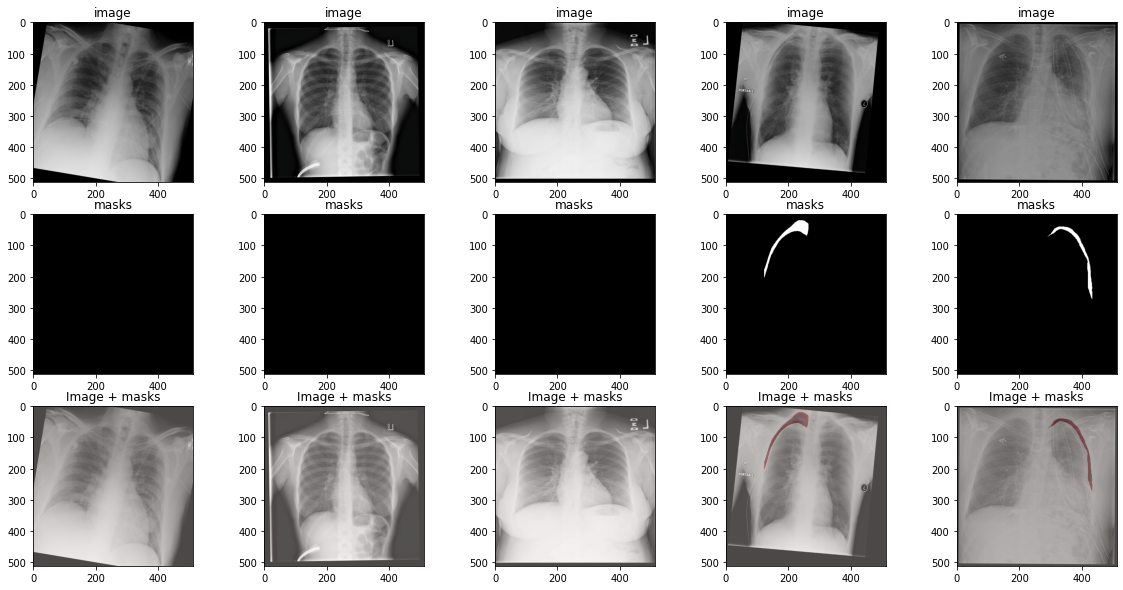

In [ ]:
plot_img(5)

# ResUnet34

In [ ]:
import torchvision
from torch.hub import load_state_dict_from_url
from torch.utils import model_zoo



class ResNetEncoder(nn.Module):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)

        resnet34 = torchvision.models.resnet34()
        # self.in_channels = in_ch
        self.conv1 = resnet34.conv1
        self.bn1 = resnet34.bn1
        self.relu = resnet34.relu
        self.maxpool = resnet34.maxpool
        self.layer1 = resnet34.layer1
        self.layer2 = resnet34.layer2
        self.layer3 = resnet34.layer3
        self.layer4 = resnet34.layer4
        del resnet34.avgpool
        del resnet34.fc

    def forward(self,x):
        x1 = self.relu(self.bn1(self.conv1(x))) #64
        x2 = self.maxpool(self.layer1(x1)) #64
        x3 = self.layer2(x2) #128
        x4 = self.layer3(x3) #256
        x5 = self.layer4(x4) #512
        return [x1,x2,x3,x4,x5]

    def load_weights(self, state):
        state_dict = self.state_dict()
        for k, v in state.items():
            if 'fc' in k:
                continue
            state_dict.update({k: v})
        model = self.load_state_dict(state_dict)
        return model



class DecoderBlock(nn.Module):
    def __init__(self,in_ch,skip_ch,out_ch):
        super().__init__()
        self.conv1 = nn.Sequential(
              nn.Conv2d(in_channels=in_ch+skip_ch,out_channels=out_ch,kernel_size=(3,3),stride=1,padding=1,bias=False),
              nn.BatchNorm2d(num_features=out_ch),
              nn.ReLU(inplace=True)
                                  )
        self.conv2 = nn.Sequential(
              nn.Conv2d(in_channels=out_ch,out_channels=out_ch,kernel_size=(3,3),stride=1,padding=1,bias=False),
              nn.BatchNorm2d(num_features=out_ch),
              nn.ReLU(inplace=True)
                                  )
    
    def forward(self, x, skip=None):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class ResUnet(nn.Module):
    def __init__(self,input_channels=3,classes=1,encoder_weights=True):
        super().__init__()
        self.encoder = ResNetEncoder()
        if encoder_weights:
          url = 'https://download.pytorch.org/models/resnet34-333f7ec4.pth'
          self.encoder.load_weights(model_zoo.load_url(url))

        self.classes = classes
        self.decoder1 = DecoderBlock(512,256,256)
        self.decoder2 = DecoderBlock(256,128,128)
        self.decoder3 = DecoderBlock(128,64,64)
        self.decoder4 = DecoderBlock(64,64,32)
        self.decoder5 = DecoderBlock(32,0,16)
        self.seg_head = nn.Conv2d(in_channels=16,out_channels=self.classes,kernel_size=(3,3),padding=3//2)

    def forward(self, x):
        enc_outs = self.encoder(x)
        x1 = self.decoder1(enc_outs[-1],enc_outs[-2])
        x2 = self.decoder2(x1,enc_outs[-3])
        x3 = self.decoder3(x2,enc_outs[-4])
        x4 = self.decoder4(x3,enc_outs[-5])
        x5 = self.decoder5(x4,skip=None)
        out = self.seg_head(x5)
        return out


In [ ]:
model = ResUnet(input_channels=3,encoder_weights=True)
model = model.to(device)
model

ResUnet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [ ]:
# import segmentation_models_pytorch as smp

# model = smp.Unet(
#     encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_weights="imagenet",     # use `imagenet` pretreined weights for encoder initialization
#     in_channels=3,                  # model input channels (1 for grayscale images, 3 for RGB, etc.)
#     classes=1,                      # model output channels (number of classes in your dataset)
#     activation=None
# )

# model = model.to(device)
# model


# Training

In [ ]:
class IOU(nn.Module):
    """
    computes iou
    """
    def __init__(self):
        super(IOU, self).__init__()

    def forward(self,inputs,targets,smooth=1):
        inputs = F.sigmoid(inputs)
        inputs = inputs.view(-1)
        target = targets.view(-1)

        intersection = (inputs*targets).sum() + smooth
        union = (inputs.sum() + targets.sum() - intersection) + smooth
        iou = intersection/union
        return iou 

class Loss(nn.Module):
   """
   computes bce + diceloss
   """
   def __init__(self,weight=0.5):
       super(Loss, self).__init__()
       self.weight = weight
       self.coef = DiceCoef()
       self.bce = nn.BCEWithLogitsLoss()
  
   def forward(self,inputs,targets):
      dice_loss = 1 - self.coef(inputs,targets) 
      bce_loss = 0.5*self.bce(inputs,targets)
      return (self.weight*dice_loss + (1 - self.weight)*bce_loss)
      # return self.bce(inputs,targets)


# 1. Apply sigmoid to predicted out if not applied earlier
# 2. flatten both predicted out as well as groundtruth to (batchsize,-1) #2d array
# 3. For predicted out make all values above 0.5 probabily as 1 ans rest 0
# 4. Find the predicted images with no masks predicted. ie, row wise sum will be zer0.
#    Also find the ground truth images where no masks are present(ie no Pneumothorax present)
#    For that we will find row wise sum for both predicted and groundtruth and check the rows in which is sum is zero for no Pneumothorax.
#    Take the common images among them.
# 5. For images with mask take the images common in case of ground truth and predicted. Find its dice
# 6. concatename both and take the mean.This becomes the dice 


def coef(probability, truth, threshold=0.5,sigmoid=True):
    '''Calculates dice of positive and negative images seperately'''
    '''probability and truth must be torch tensors'''
    
    batch_size = len(truth)
    
    with torch.no_grad():
        if sigmoid:
          probability = torch.sigmoid(probability)

        # arranging each image to 1D shape  #(batchsize, img_size*img_size)
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)
        
        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        # finding sum of each image
        t_sum = t.sum(-1)  
        p_sum = p.sum(-1)
        
        # finding images with mask from ground truth and find dice using corresponding predicted masks
        pos_index = torch.nonzero(t_sum >= 1)
        dice_pos = 2 * (p[pos_index]*t[pos_index]).sum(-1)/((p[pos_index]+t[pos_index]).sum(-1))


        # finding images without mask which are common in input and output
        neg_index = torch.nonzero(t_sum == 0)
        dice_neg = (p_sum == 0).float()
        dice_neg = dice_neg[neg_index] #will be 0 always #just to get the count and will help while taking mean

        dice = torch.cat([dice_pos, dice_neg])

        dice = torch.nan_to_num(dice.mean(), nan=0)
        dice_pos = torch.nan_to_num(dice_pos.mean(), nan=0)
        dice_neg = torch.nan_to_num(dice_neg.mean(), nan=0)

    return dice,dice_pos,dice_neg

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs

In [ ]:
# model = Unet()
# model = model.to(device)

In [ ]:
criterion = nn.BCEWithLogitsLoss()

path = 'data/models/bestmodel.pt'
writer = SummaryWriter()
min_loss = 10

train_metrics = {'loss':[],'dice':[],'dice_pos':[],'dice_neg':[]}
val_metrics = {'loss':[],'dice':[],'dice_pos':[],'dice_neg':[]}



learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
epochs = 30

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}')
    start_time = time.time()

    model.train()
    running_train_loss,running_train_coef = [],[]
    running_train_dice_pos,running_train_dice_neg = [],[]
    for image,mask in train_loader:
        image = image.to(device,dtype=torch.float)
        mask = mask.to(device,dtype=torch.float)
        pred_mask = model.forward(image)
        loss = criterion(pred_mask,mask)
        dice_coef,dice_pos,dice_neg = coef(pred_mask,mask)
        optimizer.zero_grad() # setting gradient to zero
        loss.backward()
        optimizer.step()
        running_train_loss.append(loss.item())
        running_train_coef.append(dice_coef.item())
        running_train_dice_pos.append(dice_pos.item())
        running_train_dice_neg.append(dice_neg.item())

    
    running_val_loss,running_val_coef = [],[]
    running_val_dice_pos,running_val_dice_neg = [],[]
    with torch.no_grad(): 
        model.eval()       
        for image,mask in val_loader:
            image = image.to(device,dtype=torch.float)
            mask = mask.to(device,dtype=torch.float)
            pred_mask = model.forward(image)
            loss = criterion(pred_mask,mask)
            dice_coef,dice_pos,dice_neg = coef(pred_mask,mask)
            running_val_loss.append(loss.item())
            running_val_coef.append(dice_coef.item())
            running_val_dice_pos.append(dice_pos.item())
            running_val_dice_neg.append(dice_neg.item())
    
    epoch_train_loss,epoch_train_coef = np.mean(running_train_loss) ,np.mean(running_train_coef)
    epoch_train_dice_pos,epoch_train_dice_neg = np.mean(running_train_dice_pos) ,np.mean(running_train_dice_neg)

    print('Train loss : {} | Dice coef : {} | Pos Dice coef :{} |  Neg Dice coef: {}'.format(epoch_train_loss,
                                                                                        epoch_train_coef,epoch_train_dice_pos,epoch_train_dice_neg ))
    epoch_val_loss,epoch_val_coef = np.mean(running_val_loss) ,np.mean(running_val_coef)
    epoch_val_dice_pos,epoch_val_dice_neg = np.mean(running_val_dice_pos) ,np.mean(running_val_dice_neg)

    print('Validation loss : {} | Dice coef : {} | Pos Dice coef :{} |  Neg Dice coef: {}'.format(epoch_val_loss,
                                                                                        epoch_val_coef,epoch_val_dice_pos,epoch_val_dice_neg ))


    # tensorboard writer
    train_metrics['loss'].append(epoch_train_loss)
    train_metrics['dice'].append(epoch_train_coef)
    train_metrics['dice_pos'].append(epoch_train_dice_pos)
    train_metrics['dice_neg'].append(epoch_train_dice_neg)
    
    val_metrics['loss'].append(epoch_val_loss)
    val_metrics['dice'].append(epoch_val_coef)
    val_metrics['dice_pos'].append(epoch_val_dice_pos)
    val_metrics['dice_neg'].append(epoch_val_dice_neg)

    writer.add_scalars('Loss',{'train_loss':epoch_train_loss,'validation_loss':epoch_val_loss},global_step=epoch)
    writer.add_scalars('Dice coef',{'train_dice':epoch_train_coef,'validation dice':epoch_val_coef},global_step=epoch)
    writer.add_scalars('Dice pos',{'train_pos_dice':epoch_train_dice_pos,'val_pos_dice':epoch_val_dice_pos},global_step=epoch)
    writer.add_scalars('Dice neg',{'train_neg_dice':epoch_train_dice_neg,'val_neg_dice':epoch_val_dice_neg},global_step=epoch)

    if epoch_val_loss < min_loss:
         state =  {
            'epoch': epoch,
            'state_dict': model.state_dict()
                  } 
         torch.save(state, path)
         print(f'Validation loss decreased...saving model....min loss: {epoch_val_loss}')
         min_loss = epoch_val_loss

    time_elapsed = time.time() - start_time
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('_'*120)
    torch.cuda.empty_cache()

writer.close()   

Epoch 1
Train loss : 0.28008845632665613 | Dice coef : 0.3787531551052109 | Pos Dice coef :0.0022402109550810306 |  Neg Dice coef: 0.7439740529555953
Validation loss : 0.1150954345157787 | Dice coef : 0.5009328358208955 | Pos Dice coef :0.0 |  Neg Dice coef: 1.0
Validation loss decreased...saving model....min loss: 0.1150954345157787
7m 43s
________________________________________________________________________________________________________________________
Epoch 2
Train loss : 0.07264804906361781 | Dice coef : 0.5001560550057487 | Pos Dice coef :0.0 |  Neg Dice coef: 0.99812734082397
Validation loss : 0.04776493671225078 | Dice coef : 0.5009328358208955 | Pos Dice coef :0.0 |  Neg Dice coef: 1.0
Validation loss decreased...saving model....min loss: 0.04776493671225078
7m 44s
________________________________________________________________________________________________________________________
Epoch 3
Train loss : 0.038288310777102964 | Dice coef : 0.5116021193647653 | Pos Dice coef

# Validation Inference and Visualization

In [ ]:
def predict_mask(image):
  y_pred = F.sigmoid(model.forward(image))
  return y_pred


def load_ckp(checkpoint_fpath, model, gpu=True):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    if gpu:
      model = model.to('cuda:0')
      checkpoint = torch.load(checkpoint_fpath,map_location=torch.device('cuda:0'))
    else:
      checkpoint = torch.load(checkpoint_fpath,map_location=torch.device('cpu'))
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # return model, optimizer, epoch value, min validation loss 
    return model

def mask_convert(mask):
    mask = mask.clone().cpu().detach().numpy()
    mask = mask.transpose((1,2,0))
    mask = np.squeeze(mask)
    return mask

# converting tensor to image
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image  = std * image + mean
    image = image.clip(0,1)
    image = (image * 255).astype(np.uint8)
    return image


def plot_img_target(no_,images,masks,y_pred):
    fig, axes = plt.subplots(3,no_,figsize=(20,10))    
    for i in range(0,no_):
        axes[0,i].imshow(image_convert(images[i]),cmap='bone')
        axes[0,i].set_title('image')
    for i in range(0,no_):
        axes[1,i].imshow(mask_convert(masks[i]),cmap='gray')
        axes[1,i].set_title('Masks')
    for i in range(0,no_):
        pred_mask = mask_convert(y_pred[i])
        axes[2,i].imshow(pred_mask,cmap='gray')
        axes[2,i].set_title('Mask Predicted')
    plt.show()

In [ ]:
# import segmentation_models_pytorch as smp


checkpoint_path = 'data/models/bestmodel.pt'
GPU = False

model = load_ckp(checkpoint_path, model, gpu=GPU)
model.eval()
iter_ = iter(train_loader)

## Train inference

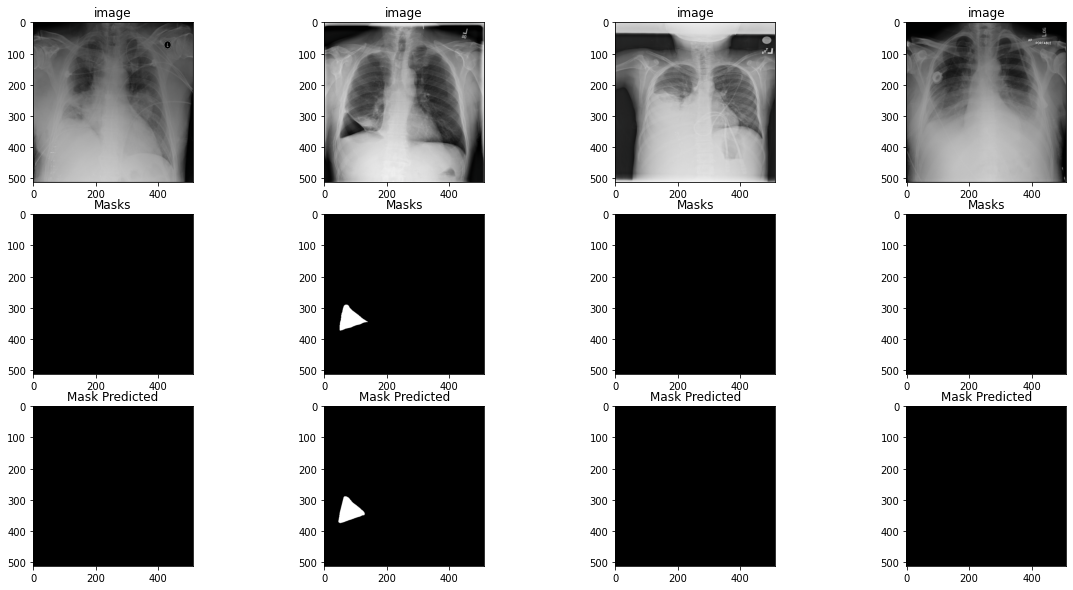

In [ ]:
# iter_ = iter(train_loader)
images,masks = next(iter_)
if GPU:
  images = images.to(device,dtype=torch.float)
  masks = masks.to(device,dtype=torch.float)
y_pred = predict_mask(images)
y_pred = (y_pred > 0.5).float()
plot_img_target(4,images,masks,y_pred)

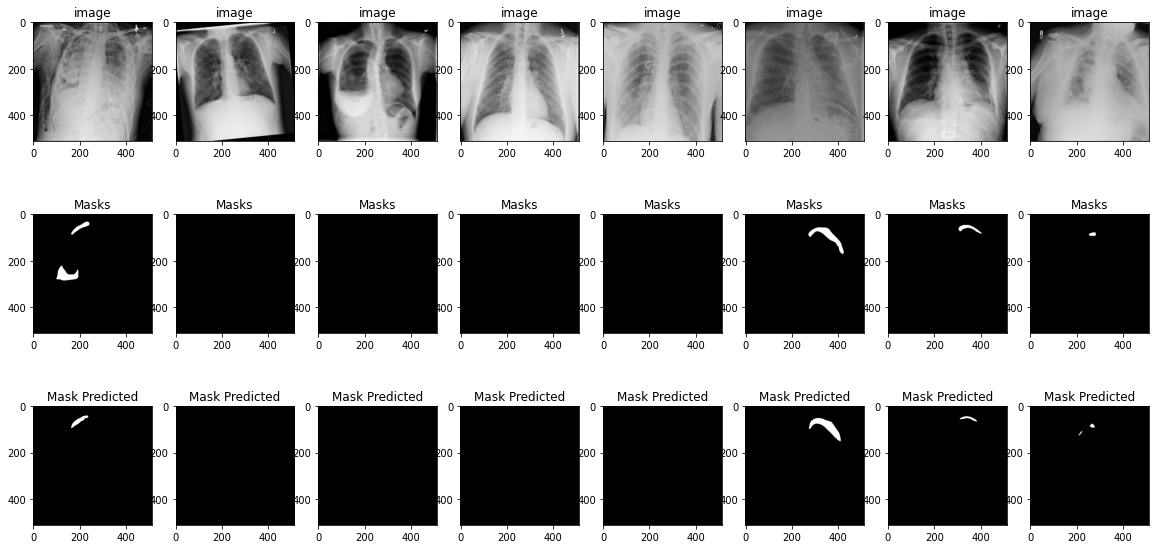

In [ ]:
images,masks = next(iter_)
if GPU:
  images = images.to(device,dtype=torch.float)
  masks = masks.to(device,dtype=torch.float)
y_pred = predict_mask(images)
y_pred = (y_pred > 0.5).float()
plot_img_target(8,images,masks,y_pred)

### Validation inference

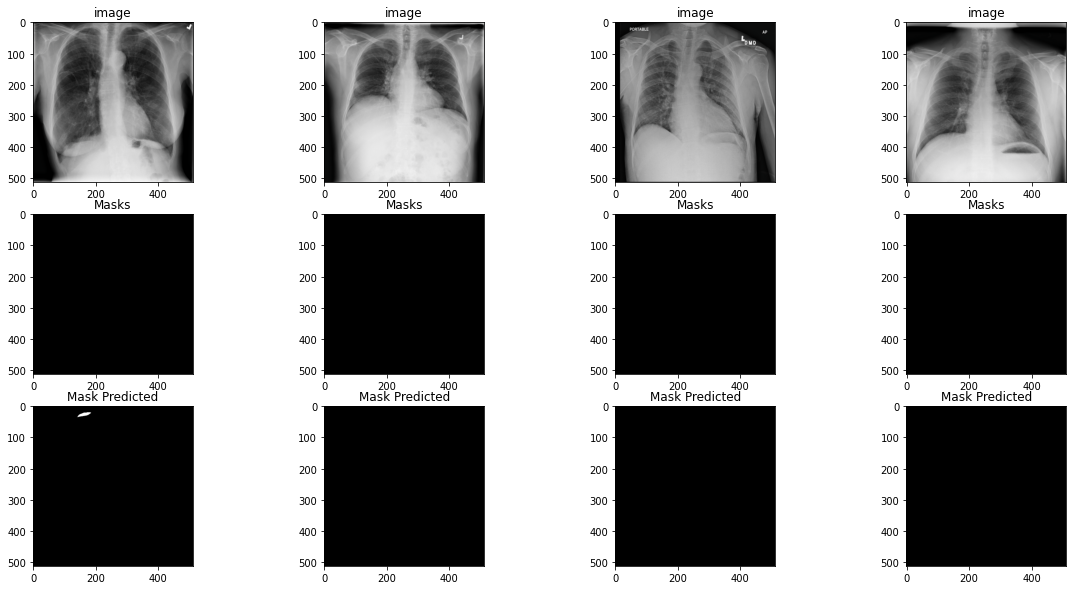

In [ ]:
iter_ = iter(val_loader)
images,masks = next(iter_)
if GPU:
  images = images.to(device,dtype=torch.float)
  masks = masks.to(device,dtype=torch.float)
y_pred = predict_mask(images)
y_pred = (y_pred > 0.5).float()
plot_img_target(4,images,masks,y_pred)

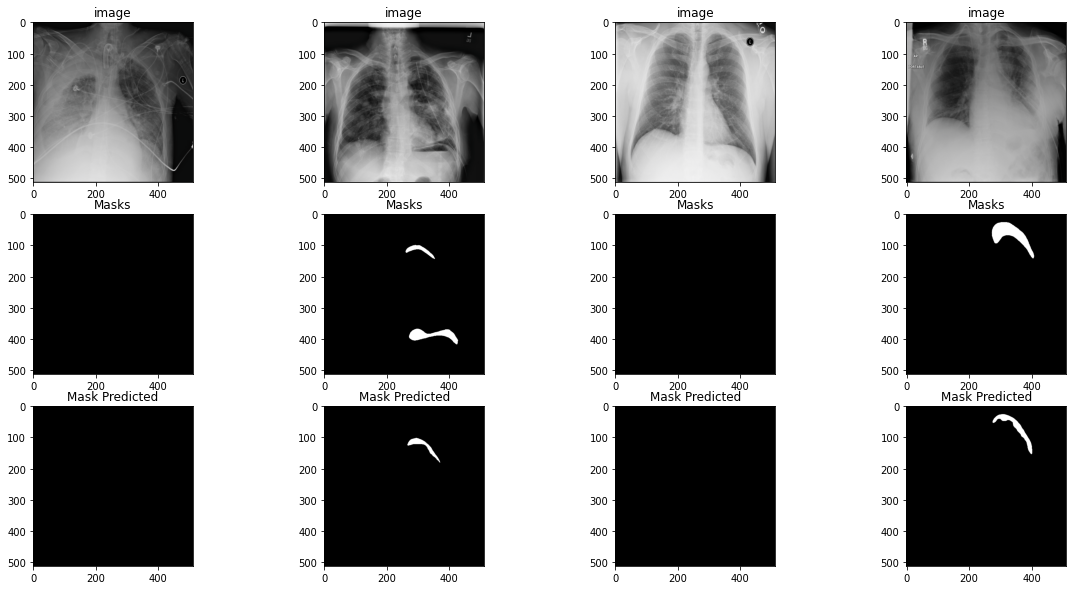

In [ ]:
images,masks = next(iter_)
if GPU:
  images = images.to(device,dtype=torch.float)
  masks = masks.to(device,dtype=torch.float)
y_pred = predict_mask(images)
y_pred = (y_pred > 0.5).float()
plot_img_target(4,images,masks,y_pred)

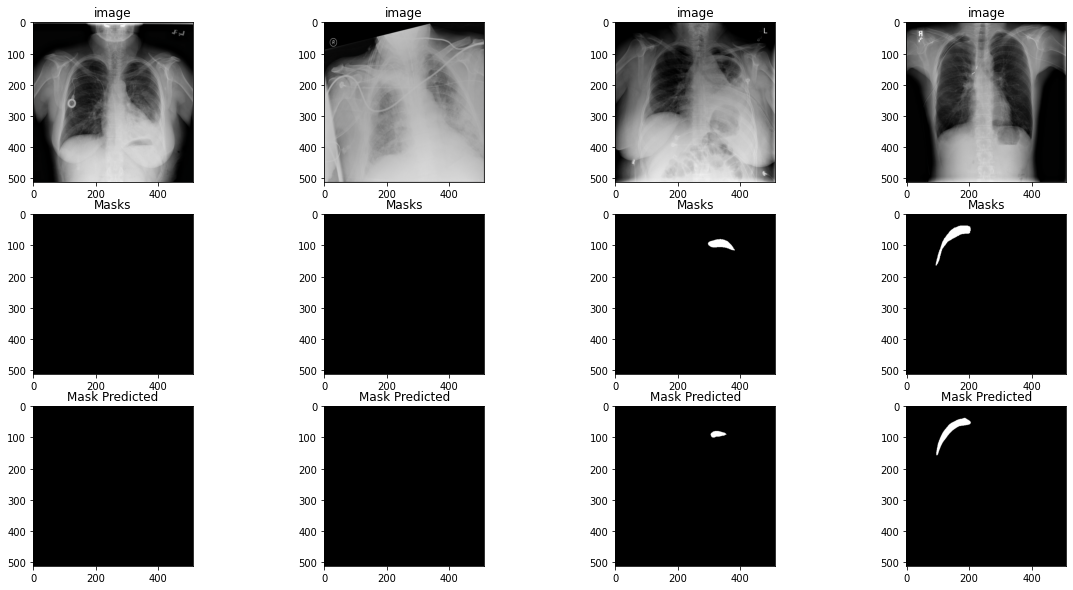

In [ ]:
images,masks = next(iter_)
if GPU:
  images = images.to(device,dtype=torch.float)
  masks = masks.to(device,dtype=torch.float)
y_pred = predict_mask(images)
y_pred = (y_pred > 0.5).float()
plot_img_target(4,images,masks,y_pred)

## Test Data Inference

In [ ]:
test_images = os.path.join(test_dir, 'images')
len(os.listdir(test_images))

3205

In [ ]:
df_sub = pd.read_csv(test_csv)
df_sub.head()

,ImageId,EncodedPixels
0,ID_c68e114ba,-1
1,ID_b5a797789,-1
2,ID_490a04f54,-1
3,ID_823ca20e1,-1
4,ID_5face2763,-1


In [ ]:
class TestDataset(Dataset):
    def __init__(self, df, root_path, size, mean, std):
        self.df = df
        self.root = root_path
        self.size = size
        self.fnames = list(df["ImageId"])
        
        self.transform = Compose(
            [
                Normalize(mean=mean, std=std, p=1),
                Resize(size, size),
                ToTensor(),
            ]
        )

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        path = os.path.join(self.root, fname + ".png")
        image = cv2.imread(path)
        images = self.transform(image=image)["image"]
        return images

    def __len__(self):
        return len(self.fnames)

In [ ]:
# utility function
def run_length_encode(component):
    component = component.T.flatten()
    start = np.where(component[1:] > component[:-1])[0]+1
    end = np.where(component[:-1] > component[1:])[0]+1
    length = end-start
    rle = []
    for i in range(len(length)):
        if i == 0:
            rle.extend([start[0], length[0]])
        else:
            rle.extend([start[i]-end[i-1], length[i]])
    rle = ' '.join([str(r) for r in rle])
    return rle

def load_ckp(checkpoint_fpath, model, gpu=True):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    if gpu:
      model = model.to('cuda:0')
      checkpoint = torch.load(checkpoint_fpath,map_location=torch.device('cuda:0'))
    else:
      checkpoint = torch.load(checkpoint_fpath,map_location=torch.device('cpu'))
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # return model, optimizer, epoch value, min validation loss 
    return model

def post_process(probability, threshold, min_size):
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((1024, 1024), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num


def mask_convert(mask):
    mask = mask.clone().cpu().detach().numpy()
    mask = mask.transpose((1,2,0))
    # mask = mask * 255.0
    mask = (mask).astype(np.uint8)
    mask = np.squeeze(mask)
    return mask


def plot_img_target(no_,images,y_pred):
    """
    plot predicted images
    """
    fig, axes = plt.subplots(3,no_,figsize=(20,10))    
    for i in range(0,no_):
        axes[0,i].imshow(image_convert(images[i]),cmap='bone')
        axes[0,i].set_title('image')
    for i in range(0,no_):
        pred_mask = mask_convert(y_pred[i])
        axes[1,i].imshow(pred_mask,cmap='gray')
        axes[1,i].set_title('Mask Predicted')
    for i in range(0,no_):
        pred_mask = mask_convert(y_pred[i])
        axes[2,i].imshow(image_convert(images[i]))
        axes[2,i].imshow(pred_mask,alpha=0.3,cmap='Reds')
        axes[2,i].set_title('Image + mask predicted')
    plt.show()

In [ ]:
size = 512
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
df = pd.read_csv(test_csv)
root_path = os.path.join(test_dir, 'images')

test_data = TestDataset(df, root_path, size, mean, std)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=16, num_workers=8, pin_memory=True)


for image in test_loader:
  print(image.shape)
  break

    

torch.Size([16, 3, 512, 512])


In [ ]:
import torchvision
from torch.hub import load_state_dict_from_url
from torch.utils import model_zoo



class ResNetEncoder(nn.Module):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)

        resnet34 = torchvision.models.resnet34()
        # self.in_channels = in_ch
        self.conv1 = resnet34.conv1
        self.bn1 = resnet34.bn1
        self.relu = resnet34.relu
        self.maxpool = resnet34.maxpool
        self.layer1 = resnet34.layer1
        self.layer2 = resnet34.layer2
        self.layer3 = resnet34.layer3
        self.layer4 = resnet34.layer4
        del resnet34.avgpool
        del resnet34.fc

    def forward(self,x):
        x1 = self.relu(self.bn1(self.conv1(x))) #64
        x2 = self.maxpool(self.layer1(x1)) #64
        x3 = self.layer2(x2) #128
        x4 = self.layer3(x3) #256
        x5 = self.layer4(x4) #512
        return [x1,x2,x3,x4,x5]

    def load_weights(self, state):
        state_dict = self.state_dict()
        for k, v in state.items():
            if 'fc' in k:
                continue
            state_dict.update({k: v})
        model = self.load_state_dict(state_dict)
        return model



class DecoderBlock(nn.Module):
    def __init__(self,in_ch,skip_ch,out_ch):
        super().__init__()
        self.conv1 = nn.Sequential(
              nn.Conv2d(in_channels=in_ch+skip_ch,out_channels=out_ch,kernel_size=(3,3),stride=1,padding=1,bias=True),
              nn.BatchNorm2d(num_features=out_ch),
              nn.ReLU(inplace=True)
                                  )
        self.conv2 = nn.Sequential(
              nn.Conv2d(in_channels=out_ch,out_channels=out_ch,kernel_size=(3,3),stride=1,padding=1,bias=True),
              nn.BatchNorm2d(num_features=out_ch),
              nn.ReLU(inplace=True)
                                  )
    
    def forward(self, x, skip=None):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class ResUnet(nn.Module):
    def __init__(self,input_channels=3,classes=1,encoder_weights=True):
        super().__init__()
        self.encoder = ResNetEncoder()
        if encoder_weights:
          url = 'https://download.pytorch.org/models/resnet34-333f7ec4.pth'
          self.encoder.load_weights(model_zoo.load_url(url))

        self.classes = classes
        self.decoder1 = DecoderBlock(512,256,256)
        self.decoder2 = DecoderBlock(256,128,128)
        self.decoder3 = DecoderBlock(128,64,64)
        self.decoder4 = DecoderBlock(64,64,32)
        self.decoder5 = DecoderBlock(32,0,16)
        self.seg_head = nn.Conv2d(in_channels=16,out_channels=self.classes,kernel_size=(3,3),padding=3//2)

    def forward(self, x):
        enc_outs = self.encoder(x)
        x1 = self.decoder1(enc_outs[-1],enc_outs[-2])
        x2 = self.decoder2(x1,enc_outs[-3])
        x3 = self.decoder3(x2,enc_outs[-4])
        x4 = self.decoder4(x3,enc_outs[-5])
        x5 = self.decoder5(x4,skip=None)
        out = self.seg_head(x5)
        return out


In [ ]:
model = ResUnet()

checkpoint_path = 'data/models/bestmodel.pt'

checkpoint = torch.load(checkpoint_path,map_location=torch.device('cpu'))
# initialize state_dict from checkpoint to model
model.load_state_dict(checkpoint['state_dict'])


model.eval()
iter_ = iter(test_loader)


### Visualizing test prediction

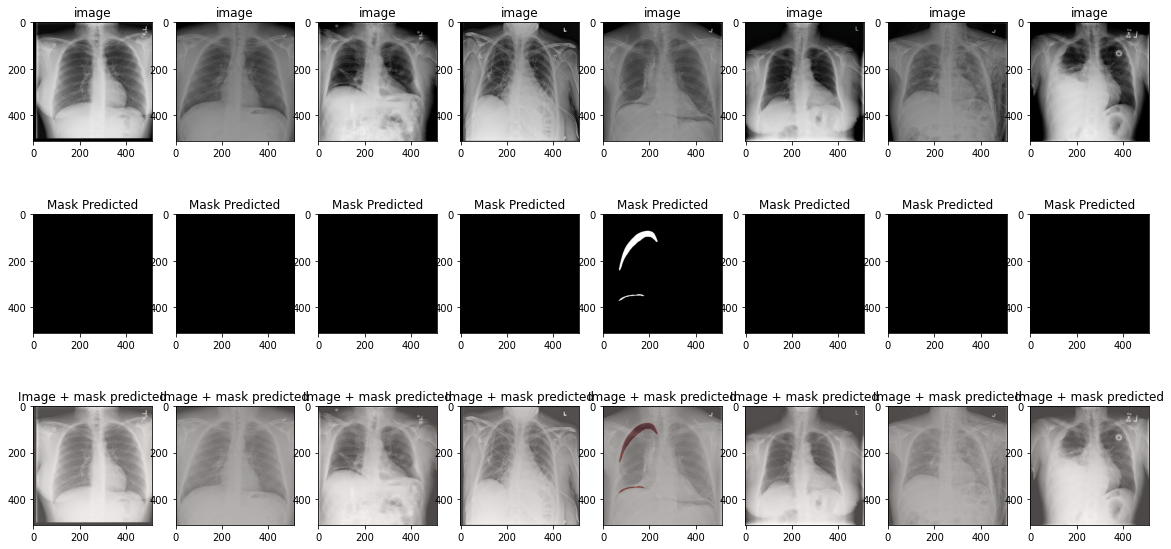

In [ ]:
images = next(iter_)

y_pred = torch.sigmoid(model(images.to(device)))
y_pred = (y_pred > 0.5).float()
plot_img_target(8,images,y_pred)


## Test submission (Kaggle)

In [ ]:
model.eval()

size = 512
min_size = 2500
best_threshold=0.5
encoded_pixels = []

for i, batch in enumerate(tqdm(test_loader)):
    preds = torch.sigmoid(model(batch.to(device)))
    preds = preds.detach().cpu().numpy()[:, 0, :, :] # (batch_size, 1, size, size) -> (batch_size, size, size)

    for mask in preds:
        if mask.shape != (1024,1024):
            mask = cv2.resize(mask, dsize=(1024,1024), interpolation=cv2.INTER_LINEAR)
        predict, num_predict = post_process(mask, best_threshold, min_size)
        if num_predict == 0:
            encoded_pixels.append('-1')
        else:
            r = run_length_encode(predict)
            encoded_pixels.append(r)


df['EncodedPixels'] = encoded_pixels
df.to_csv('submission.csv', columns=['ImageId', 'EncodedPixels'], index=False)


## Test Prediction results (Kaggle LB)

**Private LB:0.8167**<br>
**Public LB: 0.9026**

### Experimental setup

* Model: Unet with Resnet encoder
* optimizer: Adam
* batchsize : 8
* image size : 512
* Augmentation : ShiftScaleRotate
* learning rate : 0.0001
* loss: binary Cross entropy
* metric: Dice coef